In [1]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tensorflow as tf # For downloading images
from PIL import Image

In [2]:
epochs = 100
batch_size_train = 32
batch_size_test = 32

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [3]:
# Download cats and dogs dataset
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('/content/cats_and_dogs.zip', origin=URL, extract=True)
!unzip '/content/cats_and_dogs.zip'

train_path = '/content/cats_and_dogs_filtered/train'
test_path = '/content/cats_and_dogs_filtered/validation'

68616192/68606236 [==============================] - 0s 0us/step
Archive:  /content/cats_and_dogs.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2118.jp

(500, 374)


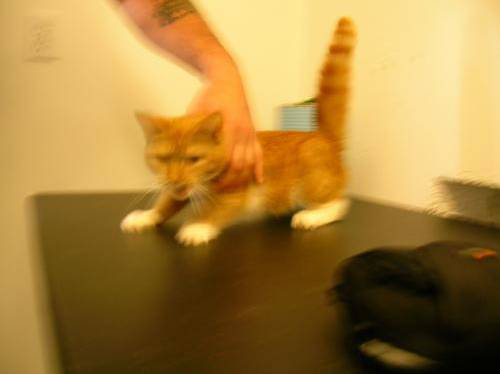

In [4]:
# Show image
img = Image.open('/content/cats_and_dogs_filtered/train/cats/cat.0.jpg')
print(img.size)
display(img)

In [5]:
# Size (224,224) for VGG16
image_transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

In [6]:
train_data = datasets.ImageFolder(train_path, transform=image_transforms)
test_data = datasets.ImageFolder(test_path, transform=image_transforms)

In [7]:
print(train_data.class_to_idx)

{'cats': 0, 'dogs': 1}


In [8]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

In [9]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [10]:
example_data.shape

torch.Size([32, 3, 224, 224])

In [11]:
def get_label(label):
  if label == 0:
    return "Cat"
  return "Dog"

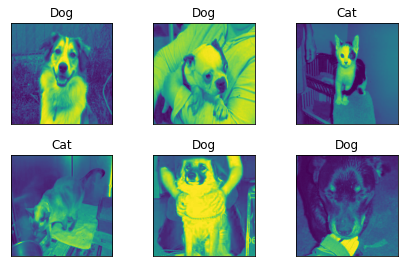

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0])
  plt.title("{}".format(get_label(example_targets[i])))
  plt.xticks([])
  plt.yticks([])

In [13]:
## Load the model based on VGG16
vgg_based = models.vgg16(pretrained=True)

## freeze the layers
for param in vgg_based.parameters():
   param.requires_grad = False

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [14]:
# Modify the last layer
number_features = vgg_based.classifier[6].in_features
features = list(vgg_based.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(number_features, 1)])
features.extend([torch.nn.Sigmoid()])
vgg_based.classifier = torch.nn.Sequential(*features)

optimizer = torch.optim.Adam(vgg_based.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True, min_lr=1e-12)
vgg_based = vgg_based.cuda()

print(vgg_based)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
train_losses = []
train_counter = []
test_accuracy = []
test_losses = []

In [17]:
def train(epoch):
  vgg_based.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()
    pred = vgg_based(data)
    pred = pred.view(-1)
    loss = F.binary_cross_entropy(pred, target.float())
    loss.backward()
    optimizer.step()

  print('Train Epoch : {}, Loss : {:.6f}'.format(epoch, loss.item()))
  train_losses.append(loss.item())
  train_counter.append(epoch)

In [18]:
def test(epoch):
  loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.cuda(), target.cuda()
      pred = vgg_based(data)
      pred = pred.view(-1)
      loss += F.binary_cross_entropy(pred, target.float(), reduction='sum').item()
      pred = torch.where(pred > 0.5, 1, 0)
      correct += torch.where(pred == target, 1, 0).sum()

  loss /= len(test_loader.dataset)
  scheduler.step(loss)

  print('\nTest Epoch : {}, Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    epoch, loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  test_losses.append(loss)
  test_accuracy.append((100 * correct / len(test_loader.dataset)).item())

In [19]:
for epoch in range(1, epochs+1):
  train(epoch)
  test(epoch)

Train Epoch : 1, Loss : 0.320376

Test Epoch : 1, Avg. loss: 0.3106, Accuracy: 911/1000 (91%)

Train Epoch : 2, Loss : 0.195008

Test Epoch : 2, Avg. loss: 0.2294, Accuracy: 932/1000 (93%)

Train Epoch : 3, Loss : 0.250218

Test Epoch : 3, Avg. loss: 0.1912, Accuracy: 936/1000 (94%)

Train Epoch : 4, Loss : 0.153157

Test Epoch : 4, Avg. loss: 0.1695, Accuracy: 951/1000 (95%)

Train Epoch : 5, Loss : 0.192871

Test Epoch : 5, Avg. loss: 0.1532, Accuracy: 953/1000 (95%)

Train Epoch : 6, Loss : 0.077518

Test Epoch : 6, Avg. loss: 0.1482, Accuracy: 955/1000 (96%)

Train Epoch : 7, Loss : 0.050229

Test Epoch : 7, Avg. loss: 0.1341, Accuracy: 953/1000 (95%)

Train Epoch : 8, Loss : 0.074227

Test Epoch : 8, Avg. loss: 0.1288, Accuracy: 953/1000 (95%)

Train Epoch : 9, Loss : 0.074798

Test Epoch : 9, Avg. loss: 0.1309, Accuracy: 957/1000 (96%)

Train Epoch : 10, Loss : 0.019981

Test Epoch : 10, Avg. loss: 0.1234, Accuracy: 951/1000 (95%)

Train Epoch : 11, Loss : 0.045417

Test Epoch : 

Text(0, 0.5, 'Loss')

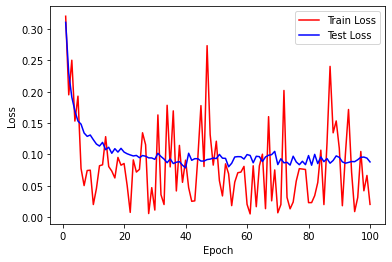

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(train_counter, train_losses, color='red')
plt.plot(train_counter, test_losses, color='blue')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

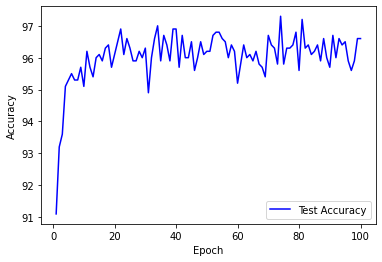

In [21]:
fig = plt.figure()
plt.plot(train_counter, test_accuracy, color='blue')
plt.legend(['Test Accuracy'], loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')